In [1]:
# Importing important libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cars_data = pd.read_csv('car.csv')
cars_data.head()

,price,maint,comfort,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,med,4,4,big,med,acc
4,vhigh,med,4,4,big,high,acc


In [3]:
cars_data.groupby(cars_data['safety']).count()['price']

safety
acc      17
unacc    24
Name: price, dtype: int64

In [4]:
def entropy(probs):  
    import math
    return sum( [-prob * math.log(prob, 2) for prob in probs] )

#Function to calulate the entropy of the given Data Sets/List with respect to target attributes
def entropy_of_list(a_list):  
    from collections import Counter
    cnt = Counter(x for x in a_list)   # Counter calculates the propotion of class
    num_instances = len(a_list)*1.0   # = 8
    probs = [x / num_instances for x in cnt.values()]  # x means no of YES/NO
    return entropy(probs) # Call Entropy :

total_entropy = entropy_of_list(cars_data['safety'])

print("\n Total Entropy of Car Safety Data Set:",total_entropy)


 Total Entropy of Car Safety Data Set: 0.9788698505067785


In [5]:
def information_gain(df, split_attribute_name, target_attribute_name, trace=0):
    '''
    Takes a DataFrame of attributes, and quantifies the entropy of a target
    attribute after performing a split along the values of another attribute.
    '''
    # Split Data by Possible Vals of Attribute:
    df_split = df.groupby(split_attribute_name)
    # Calculate Entropy for Target Attribute, as well as
    # Proportion of Obs in Each Data-Split
    nobs = len(df.index) * 1.0
    df_agg_ent = df_split.agg({target_attribute_name : [entropy_of_list, lambda x: len(x)/nobs] })[target_attribute_name]
    df_agg_ent.columns = ['Entropy', 'PropObservations']
    
    # Calculate Information Gain:
    new_entropy = sum( df_agg_ent['Entropy'] * df_agg_ent['PropObservations'] )
    old_entropy = entropy_of_list(df[target_attribute_name])
    return old_entropy - new_entropy

In [6]:
def id3(df, target_attribute_name, attribute_names, default_class=None):
    
    ## Tally target attribute:
    from collections import Counter
    cnt = Counter(x for x in df[target_attribute_name])# class of YES /NO
    
    ## First check: Is this split of the dataset homogeneous?
    if len(cnt) == 1:
        return next(iter(cnt))  # next input data set, or raises StopIteration when EOF is hit.
    
    ## Second check: Is this split of the dataset empty?
    # if yes, return a default value
    elif df.empty or (not attribute_names):
        return default_class  # Return None for Empty Data Set
    
    ## Otherwise: This dataset is ready to be devied up!
    else:
        # Get Default Value for next recursive call of this function:
        default_class = max(cnt.keys()) #No of YES and NO Class
        # Compute the Information Gain of the attributes:
        gainz = [information_gain(df, attr, target_attribute_name) for attr in attribute_names] #
        index_of_max = gainz.index(max(gainz)) # Index of Best Attribute
        # Choose Best Attribute to split on:
        best_attr = attribute_names[index_of_max]
        
        # Create an empty tree, to be populated in a moment
        tree = {best_attr:{}} # Iniiate the tree with best attribute as a node 
        remaining_attribute_names = [i for i in attribute_names if i != best_attr]
        
        # Split dataset
        # On each split, recursively call this algorithm.
        # populate the empty tree with subtrees, which
        # are the result of the recursive call
        for attr_val, data_subset in df.groupby(best_attr):
            subtree = id3(data_subset,
                        target_attribute_name,
                        remaining_attribute_names,
                        default_class)
            tree[best_attr][attr_val] = subtree
        return tree

In [7]:
# Get Predictor Names (all but 'class')
attribute_names = list(cars_data.columns)
print("List of Attributes:", attribute_names) 
attribute_names.remove('safety') #Remove the class attribute 
print("Predicting Attributes:", attribute_names)

List of Attributes: ['price', 'maint', 'comfort', 'doors', 'persons', 'lug_boot', 'safety']
Predicting Attributes: ['price', 'maint', 'comfort', 'doors', 'persons', 'lug_boot']


In [8]:
# Run Algorithm:
from pprint import pprint
tree = id3(cars_data,'safety',attribute_names)
print("The Resultant Decision Tree is :\n")
pprint(tree)
attribute = next(iter(tree))
print("Best Attribute :\n",attribute)
print("Tree Keys:\n",tree[attribute].keys())

The Resultant Decision Tree is :

{'lug_boot': {'high': {'doors': {'2': 'unacc',
                                 '4': 'acc',
                                 'more': {'comfort': {'2': 'unacc',
                                                      '3': 'acc',
                                                      '4': 'acc'}}}},
              'low': 'unacc',
              'med': {'persons': {'big': {'doors': {'2': 'unacc',
                                                    '4': 'acc',
                                                    'more': 'acc'}},
                                  'med': {'doors': {'2': 'unacc',
                                                    '4': 'acc',
                                                    'more': 'acc'}},
                                  'small': 'unacc'}}}}
Best Attribute :
 lug_boot
Tree Keys:
 dict_keys(['high', 'low', 'med'])


In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cars_data['price']= label_encoder.fit_transform(cars_data['price'])
cars_data['maint']= label_encoder.fit_transform(cars_data['maint'])
cars_data['comfort']= label_encoder.fit_transform(cars_data['comfort'])
cars_data['persons']= label_encoder.fit_transform(cars_data['persons'])
cars_data['lug_boot']= label_encoder.fit_transform(cars_data['lug_boot'])
cars_data['doors']= label_encoder.fit_transform(cars_data['doors'])
cars_data['safety']= label_encoder.fit_transform(cars_data['safety'])

Accuracy: 0.6153846153846154


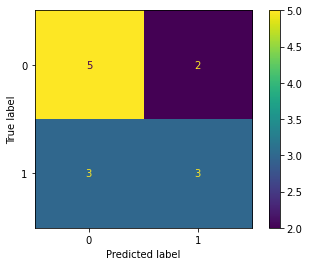

In [10]:
X = cars_data[['price','maint','comfort','doors','persons','lug_boot']]
y = cars_data['safety']
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
metrics.plot_confusion_matrix(clf,X_test,y_test)


In [22]:
for i in cars_data.columns:
    print(i,' : ',cars_data[i].unique())
    print('Entropy of',i,':',entropy_of_list(cars_data[i]))
    print('Gain of',i,':',abs(total_entropy-entropy_of_list(cars_data[i])),'\n')

price  :  [1 0]
Entropy of price : 0.5349436990971067
Gain of price : 0.44392615140967184 

maint  :  [2 1 0]
Entropy of maint : 0.6533523081769443
Gain of maint : 0.3255175423298342 

comfort  :  [0 2 1 3]
Entropy of comfort : 1.249363946973598
Gain of comfort : 0.27049409646681943 

doors  :  [0 1 2]
Entropy of doors : 1.5642357041653152
Gain of doors : 0.5853658536585367 

persons  :  [2 0 1]
Entropy of persons : 1.5707113784408682
Gain of persons : 0.5918415279340896 

lug_boot  :  [1 2 0]
Entropy of lug_boot : 1.574008923045204
Gain of lug_boot : 0.5951390725384254 

safety  :  [1 0]
Entropy of safety : 0.9788698505067785
Gain of safety : 0.0 



In [34]:
# Thus, main attribute is lug_boot
cars_data = pd.read_csv('car.csv')
cars_mid = cars_data.loc[cars_data['lug_boot'] == 'med']
cars_low = cars_data.loc[cars_data['lug_boot'] == 'low']
cars_high = cars_data.loc[cars_data['lug_boot'] == 'high']

In [39]:
for i in cars_mid:
    print(i,' : ',cars_mid[i].unique())
    print('Entropy of',i,':',entropy_of_list(cars_mid[i]))
    print('Gain of',i,':',abs(total_entropy-entropy_of_list(cars_mid[i])),'\n')

price  :  ['vhigh' 'high']
Entropy of price : 0.6193821946787638
Gain of price : 0.3594876558280148 

maint  :  ['vhigh' 'med' 'low']
Entropy of maint : 0.7732283485249176
Gain of maint : 0.20564150198186093 

comfort  :  ['2' '4' '5more']
Entropy of comfort : 1.1401156785146092
Gain of comfort : 0.1612458280078306 

doors  :  ['2' '4' 'more']
Entropy of doors : 1.5262349099495227
Gain of doors : 0.5473650594427442 

persons  :  ['small' 'big' 'med']
Entropy of persons : 1.5485806065228545
Gain of persons : 0.5697107560160759 

lug_boot  :  ['med']
Entropy of lug_boot : 0.0
Gain of lug_boot : 0.9788698505067785 

safety  :  ['unacc' 'acc']
Entropy of safety : 0.9957274520849256
Gain of safety : 0.016857601578147086 



In [40]:
for i in cars_high:
    print(i,' : ',cars_high[i].unique())
    print('Entropy of',i,':',entropy_of_list(cars_high[i]))
    print('Gain of',i,':',abs(total_entropy-entropy_of_list(cars_high[i])),'\n')

price  :  ['vhigh' 'high']
Entropy of price : 0.5435644431995964
Gain of price : 0.43530540730718215 

maint  :  ['vhigh' 'med' 'low']
Entropy of maint : 0.6685644431995964
Gain of maint : 0.31030540730718215 

comfort  :  ['2' '4' '3' '5more']
Entropy of comfort : 1.4237949406953985
Gain of comfort : 0.4449250901886199 

doors  :  ['2' '4' 'more']
Entropy of doors : 1.5461796919474975
Gain of doors : 0.5673098414407189 

persons  :  ['small' 'big' 'med']
Entropy of persons : 1.5612781244591327
Gain of persons : 0.5824082739523542 

lug_boot  :  ['high']
Entropy of lug_boot : 0.0
Gain of lug_boot : 0.9788698505067785 

safety  :  ['unacc' 'acc']
Entropy of safety : 0.8960382325345575
Gain of safety : 0.08283161797222105 



In [41]:
for i in cars_low:
    print(i,' : ',cars_low[i].unique())
    print('Entropy of',i,':',entropy_of_list(cars_low[i]))
    print('Gain of',i,':',abs(total_entropy-entropy_of_list(cars_low[i])),'\n')

price  :  ['vhigh' 'high']
Entropy of price : 0.41381685030363374
Gain of price : 0.5650530002031449 

maint  :  ['vhigh' 'low']
Entropy of maint : 0.41381685030363374
Gain of maint : 0.5650530002031449 

comfort  :  ['2' '4']
Entropy of comfort : 0.9182958340544896
Gain of comfort : 0.06057401645228899 

doors  :  ['2' '4' 'more']
Entropy of doors : 1.584962500721156
Gain of doors : 0.6060926502143775 

persons  :  ['small' 'big' 'med']
Entropy of persons : 1.584962500721156
Gain of persons : 0.6060926502143775 

lug_boot  :  ['low']
Entropy of lug_boot : 0.0
Gain of lug_boot : 0.9788698505067785 

safety  :  ['unacc']
Entropy of safety : 0.0
Gain of safety : 0.9788698505067785 



In [ ]:
# For med, persons has highest gain 